In [1]:
import re
from bs4 import BeautifulSoup
import os
import json
import uuid
from models import PDChuDe, PDDeMuc, PDChuong, PDDieu, PDTable, PDFile, PDMucLienQuan
from database import db
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
from pyvi.ViTokenizer import tokenize
import matplotlib.pyplot as plt
import numpy as np
from langchain.text_splitter import RecursiveCharacterTextSplitter
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
_MAX_TKNLEN = 512
SPLIST_MODEL_NAME = "vinai/PhoGPT-4B-Chat"
EMBEDDING_MODEL = "Merikatorihuhu/SimCSE-finetuned-vietnamese-legal-documents"
chunk_overlap = 0
tokenizer = AutoTokenizer.from_pretrained(SPLIST_MODEL_NAME)
model = SentenceTransformer(EMBEDDING_MODEL)

In [ ]:
def convert_roman_to_num(roman_num):
    roman_num = roman_num.upper()
    roman_to_num = {'I': 10, 'V': 50, 'X': 100, 'L': 500, 'C': 1000, 'D': 5000, 'M': 10000}
    alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
    num = 0
    for i in range(len(roman_num)):
        romain_char = roman_num[i]
        if romain_char not in roman_to_num.keys():
            num += alphabet.index(romain_char) + 1
            continue
        if i > 0 and roman_to_num[romain_char] > roman_to_num[roman_num[i - 1]]:
            num += roman_to_num[romain_char] - 2 * roman_to_num[roman_num[i - 1]]
        else:
            num += roman_to_num[romain_char]
    return num

def extract_input(input_string):
    # Define a regular expression pattern to match the content inside parentheses
    pattern = r"\((.*?)\)"
    # Use re.search to find the first match in the input string
    match = re.search(pattern, input_string)
    # Check if a match is found
    if match:
        # Extract and return the content inside parentheses
        return match.group(1)
    else:
        # Return None if no match is found
        return None

In [ ]:

# CREATE-DROP Tất cả dữ liệu
# db.drop_tables([PDMucLienQuan, PDTable, PDFile, PDDieu, PDChuong, PDDeMuc, PDChuDe], cascade=True)  # Added cascade=True for PostgreSQL
# db.create_tables([PDMucLienQuan, PDTable, PDFile, PDDieu, PDChuong, PDDeMuc, PDChuDe])

In [ ]:

checkpoint = None
# Đọc Chủ đề
print("Load Chủ Đề Từ File ...")
with open("data/chude.json", "r", encoding='utf-8') as chude_file:
    chudes = json.load(chude_file)
print("Insert tất cả chủ đề...")
try:
    with db.atomic():
        # Use chunks for bulk insert to prevent memory issues
        chunk_size = 100
        for idx in range(0, len(chudes), chunk_size):
            chunk = chudes[idx:idx + chunk_size]
            PDChuDe.bulk_create([
                PDChuDe(name=chude["name"], order=chude["order"], id=chude["id"]) 
                for chude in chunk
            ], batch_size=chunk_size)
    print("Inserted tất cả chủ đề pháp điển!")
except Exception as e:
    print(f"Error inserting chude: {str(e)}")

# Đọc Đề mục
print("Load Đề Mục Từ File ...")
with open("data/demuc.json", "r", encoding='utf-8') as demuc_file:
    demucs = json.load(demuc_file)

print("Insert tất cả đề mục...")
try:
    with db.atomic():
        # Use chunks for bulk insert
        chunk_size = 100
        for idx in range(0, len(demucs), chunk_size):
            chunk = demucs[idx:idx + chunk_size]
            PDDeMuc.bulk_create([
                PDDeMuc(name=demuc["title"], order=demuc["order"], 
                       id=demuc["id"], chude_id=demuc["chude_id"]) 
                for demuc in chunk
            ], batch_size=chunk_size)
except Exception as e:
    print(f"Error inserting demuc: {str(e)}")
print("Inserted tất cả đề mục pháp điển!")

print("Load Tree Nodes Từ File ...")
with open("data/treeNode.json", "r", encoding='utf-8') as tree_nodes_file:
    tree_nodes = json.load(tree_nodes_file)

print("Insert tất cả nodes...")
demuc_directory = os.fsencode("demuc")
dieus_lienquan = []

count = 0
if checkpoint:
    isSkipping = True
else:
    isSkipping = False

for file in os.listdir(demuc_directory):
    file_name = os.fsdecode(file)
    with open("demuc/" + file_name, "r", encoding='utf-8') as demuc_file:
        count += 1
        if file_name == checkpoint:
            isSkipping = False
        if isSkipping:
            continue

        demuc_html = demuc_file.read()
        demuc_html = BeautifulSoup(demuc_html, "html.parser")
        demuc_nodes = [node for node in tree_nodes if node["demuc_id"] == file_name.split(".")[0]]

        if len(demuc_nodes) == 0:
            print("Không tìm thấy node cho đề mục: " + file_name)
            continue

        demuc_chuong = [node for node in demuc_nodes if node["name"].startswith("Chương ")]
        chuongs_data = []

        # Insert chapters using a transaction
        for chuong in demuc_chuong:
            mapc = chuong["mapc"]
            order = convert_roman_to_num(chuong["chi_muc"])
            try:
                chuong_data = PDChuong.create(
                    name=chuong["name"],
                    mapc=mapc,
                    chimuc=chuong["chi_muc"],
                    order=order,
                    demuc_id=chuong["demuc_id"]
                )
                chuongs_data.append(chuong_data)
            except Exception as e:
                print(f"Error inserting chuong {mapc}: {str(e)}")
                continue

        print(f'Insert {len(demuc_chuong)} chương của đề mục {file_name}')
        # Create dummy chapter if needed
        if len(chuongs_data) == 0:
            try:
                chuong_data = PDChuong.create(
                    name="",
                    mapc=str(uuid.uuid4()),
                    chimuc="0",
                    order=0,
                    demuc_id=file_name.split(".")[0]
                )
                chuongs_data.append(chuong_data)
            except Exception as e:
                print(f"Error creating dummy chapter: {str(e)}")

        demuc_dieus = [node for node in demuc_nodes if node not in demuc_chuong]
        print(f'Đề mục {file_name} có {len(demuc_chuong)} chương và {len(demuc_dieus)} điều')
        
        # Process articles
        order = 0
        for dieu in demuc_dieus:
                try:
                    # Process article data...
                    # (rest of the dieu processing code remains the same)
                    if len(chuongs_data) == 1:
                        dieu["id"] = chuongs_data[0].mapc
                    else:
                        for chuong in chuongs_data:
                            if dieu["mapc"].startswith(chuong.mapc):
                                dieu["id"] = chuong.mapc
                                break
                    mapc = dieu["mapc"]
                    dieu_html = demuc_html.select(f'a[name="{mapc}"]')[0]
                    name = dieu_html.nextSibling
                    ghi_chu_html = dieu_html.parent.nextSibling
                    vbqppl = ghi_chu_html.text if ghi_chu_html else None
                    vbqppl_link = ghi_chu_html.select("a")[0]["href"] if ghi_chu_html.select("a") else None
                    noidung_html = dieu_html.parent.find_next("p", {"class": "pNoiDung"})
                    noidung = ""
                    tables = []
                    
                    for content in noidung_html.contents:
                        if content.name == "table":
                            tables.append(str(content))
                            continue
                        noidung += str(content.text.strip()) + "\n"

                    # Create PDDieu record
                    dieu_record = PDDieu.create(
                        name=name, 
                        mapc=mapc,
                        chimuc=dieu["chi_muc"],
                        order=order,
                        noidung=noidung,
                        vbqppl=vbqppl,
                        vbqppl_link=vbqppl_link,
                        demuc_id=dieu["demuc_id"],
                        chuong_id=dieu["id"],
                        chude_id=dieu.get("chude_id")  # Add null check for ChuDeID
                    )

                    # Create table records
                    for table in tables:
                        PDTable.create(dieu_id=mapc, html=table)
                    # Process related files and links
                    element = noidung_html.nextSibling
                    while element and element.name == "a":
                        link = element["href"]
                        try:
                            PDFile.create(dieu_id=dieu["mapc"], link=link, path="")
                        except Exception as e:
                            print(f"Lỗi insert file {link}: {str(e)}")
                        element = element.nextSibling
                    # Process related articles
                    if (element and element.name == "p" and 
                        element["class"] and element["class"][0] == "pChiDan"):
                        lienquans_html = element.select("a")
                        for lienquan_html in lienquans_html:
                            if not "onclick" in lienquan_html.attrs or lienquan_html["onclick"] == "":
                                continue
                            mapc_lienquan = extract_input(lienquan_html["onclick"]).replace("'", "")
                            dieus_lienquan.append({
                                "dieu_id1": dieu["mapc"],
                                "dieu_id2": mapc_lienquan
                            })
                    order += 1
                except Exception as e:
                    print(f"Error processing dieu {dieu['mapc']}: {str(e)}")
                    continue
print("Inserted tất cả nodes pháp điển!")
# Insert related articles
print("Inserting related articles...")
for dieu_lienquan in dieus_lienquan:
    try:
        PDMucLienQuan.create(dieu_id1=dieu_lienquan["dieu_id1"], dieu_id2=dieu_lienquan["dieu_id2"])
    except:
        print(f'Không thể insert liên quan {dieu_lienquan["dieu_id1"]} - {dieu_lienquan["dieu_id2"]}')
    print(f'Inserted liên quan {dieu_lienquan["dieu_id1"]} - {dieu_lienquan["dieu_id2"]}')

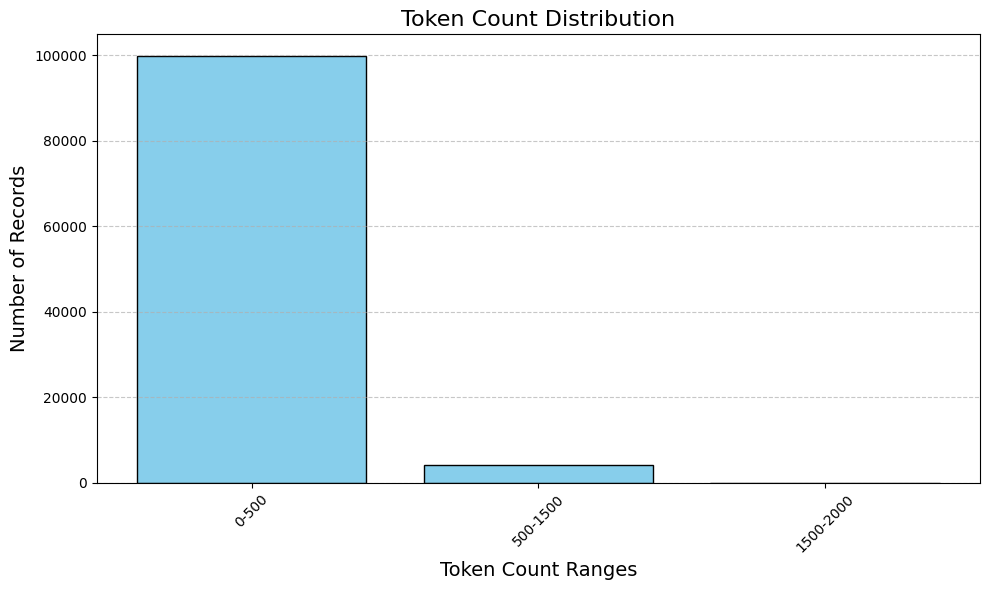

In [3]:

# Load token counts from the CSV generated in the first script
df = pd.read_csv("token_counts.csv")

# Define ranges for categorization
ranges = [0, 500 , 1500 , 2000]
df["range"] = pd.cut(df["token_count"], bins=ranges, labels=[f"{ranges[i]}-{ranges[i+1]}" for i in range(len(ranges)-1)])

# Count the number of records in each range
range_counts = df["range"].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(range_counts.index, range_counts.values, color="skyblue", edgecolor="black")
plt.title("Token Count Distribution", fontsize=16)
plt.xlabel("Token Count Ranges", fontsize=14)
plt.ylabel("Number of Records", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Cấu hình
queries = {
    "select_mapc_noidung": "SELECT mapc, name, noidung FROM PDDieu",
    "embedding": "INSERT INTO embedding_v2 (mapc, name, noidung, embedding) VALUES (%s, %s, %s, %s);",
}
# Khởi tạo mô hình và tokenizer
text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer,
    chunk_size=_MAX_TKNLEN,
    chunk_overlap=chunk_overlap,
    add_start_index=True,
    strip_whitespace=True)
# Kết nối database
cursor = db.cursor()
# Lấy dữ liệu từ bảng PDDieu
cursor.execute(queries["select_mapc_noidung"])
rows = cursor.fetchall()
for row in rows:
    mapc, name, noidung = row
    if not noidung:  # Bỏ qua nếu nội dung rỗng
        continue
    # Chia nhỏ nội dung thành các đoạn
    splits = text_splitter.split_text(noidung)
    for txtchunk in splits:
        try:
            # Tính embedding
            embeddings = model.encode(txtchunk)
            fnorm = np.linalg.norm(embeddings)
            lst = list(embeddings/fnorm)
            embeddings = json.dumps(lst, default=np.float64)
            # Lưu embedding vào cơ sở dữ liệu
            cursor.execute(queries["embedding"], (mapc, name, txtchunk, embeddings))
            print(f"Đã embedding: {name}")
        except Exception as e:
            print(f"Lỗi khi xử lý {name}: {e}")
# Đảm bảo thay đổi được lưu lại
db.commit()